# Fitting a PHA dataset using the object API

The aim of this notebook is to highlight some of the ways that you can use Sherpa to analyze PHA data (i.e. Astronomical X-ray spectra) using the object API rather than the "UI" layer (which is what we 
[document to users in CIAO](http://cxc.harvard.edu/sherpa/)). It is perhaps not as wordy as I'd like, but I'd rather this get released than spend time on polishing the prose, especially as I'm writing this while my son is in swim club.

This notebook uses the recently-released Sherpa 4.9.1 and Python 3.6. If you have cloned my
[sherpa notebook repository](https://github.com/DougBurke/sherpa-standalone-notebooks) then you can follow along with the following commands (some interaction may be required by conda ;-). There should be nothing in this notebook that requires either Sherpa 4.9.1 or Python 3.6 (e.g. it can be used by CIAO 4.9 users).

    % conda create -n=sherpa-standalone-notebooks python=3.6
    % source activate sherpa-standalone-notebooks
    % conda install -c https://conda.anaconda.org/sherpa sherpa astropy matplotlib jupyter ipython
    ...
        astropy:            2.0.1-np113py36_0       
        ipython:            6.1.0-py36_0            
        matplotlib:         2.0.2-np113py36_0       
        numpy:              1.13.1-py36_0           
        sherpa:             4.9.1-py36_0      sherpa
    ...
    % jupyter notebook

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on August 8 2017. This notebook, and others that may be of interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository or on Twitter - at 
[@doug_burke](https://twitter.com/doug_burke) - if you have any questions.

## Last run

Let's start off by seeing when I last ran this notebook

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2017-08-08 19:38'

## What version of Sherpa is being used?

In [2]:
import sherpa
print(sherpa._version.get_versions())

{'version': '4.9.1', 'full': '3e8ad5a04764115e05c14c8c06c8a7910c714711'}


## Load in the main modules

In [3]:
from sherpa.astro import ui
from matplotlib import pyplot as plt

import numpy as np

%matplotlib inline

## What data shall we use?

In this example I am going to use a PHA file - and responses - I obtained from
[version 1.1 of the Chandra Source Catalog](https://cxc.harvard.edu/csc/). I'm not trying to use a physically-motivated model here, just show how you can set up and evaluate a model expression to include the effects of the instrument model (i.e. the Ancillary Response Function, ARF, and Redistribution Matrix Function ,RMF).

In [4]:
ls data/pha

acisf01575_001N001_r0043_arf3.fits.gz  acisf01575_001N001_r0043_rmf3.fits.gz
acisf01575_001N001_r0043_pha3.fits.gz


## A simple fit using the UI layer

This section shows some common steps taken when analysing PHA data using the UI layer. I shall
be attempting to recreate them using the object API below!

In [5]:
ui.load_pha('data/pha/acisf01575_001N001_r0043_pha3.fits.gz')

read ARF file data/pha/acisf01575_001N001_r0043_arf3.fits
read RMF file data/pha/acisf01575_001N001_r0043_rmf3.fits
read background file data/pha/acisf01575_001N001_r0043_pha3.fits


Since I do not have the XSPEC models available in this version of Sherpa I am going to
restrict to a non-physical fit (a straight power law with no absorption component):

Dataset               = 1
Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 14098.2
Final fit statistic   = 44.3833 at function evaluation 22
Data points           = 58
Degrees of freedom    = 56
Probability [Q-value] = 0.868671
Reduced statistic     = 0.792559
Change in statistic   = 14053.8
   pl.gamma       2.25192     
   pl.ampl        4.60287e-05 


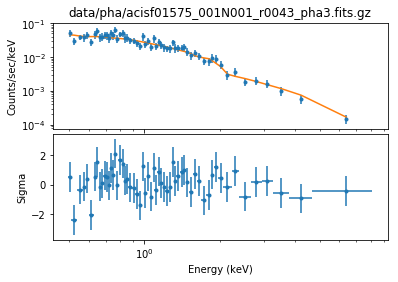

In [6]:
ui.set_source(ui.powlaw1d.pl)
ui.subtract()
pl.ampl = 1e-4
ui.get_data_plot_prefs()['xlog'] = True
ui.get_data_plot_prefs()['ylog'] = True
ui.group_counts(20)
ui.notice(0.5, 8)
ui.fit()
ui.plot_fit_delchi()

Let's also do some basic error analysis:

In [7]:
ui.covar()

Dataset               = 1
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pl.gamma          2.25192   -0.0572124    0.0572124
   pl.ampl       4.60287e-05 -1.51642e-06  1.51642e-06


In [8]:
ui.conf()

pl.ampl lower bound:	-1.51642e-06
pl.ampl upper bound:	1.51642e-06
pl.gamma lower bound:	-0.0565873
pl.gamma upper bound:	0.0578375
Dataset               = 1
Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pl.gamma          2.25192   -0.0565873    0.0578375
   pl.ampl       4.60287e-05 -1.51642e-06  1.51642e-06


The results of both of these are stored for later (hardly-ominous forshadowing):

In [9]:
covar_ui = ui.get_covar_results()
conf_ui = ui.get_conf_results()

This section is finished off by a quick interval-projection plot, to see how sensitive the fit is to the `gamma` parameter of the powerlaw, and a look at the best-fit statistic value:

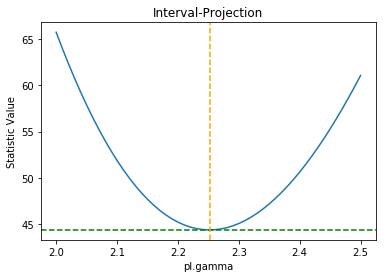

In [10]:
ui.int_proj(pl.gamma, min=2, max=2.5, nloop=51)

In [11]:
stat_ui = ui.calc_stat()
print(stat_ui)

44.383283673541435


---

## How do I recreate this with the object API?

I have split up the above into several steps:

  - load the data and responses
  - adjust the data
  - create the model
  - fit
  - error analysis

### Load the data and responses

This uses the `sherpa.astro.io` module directly, which may not be a good idea (it's not clear to me yet whether this module is well suited for general use), but it's what is currently easiest:

In [12]:
from sherpa.astro.io import read_pha

In [13]:
pha = read_pha('data/pha/acisf01575_001N001_r0043_pha3.fits.gz')
print(pha)

read ARF file data/pha/acisf01575_001N001_r0043_arf3.fits
read RMF file data/pha/acisf01575_001N001_r0043_rmf3.fits
read background file data/pha/acisf01575_001N001_r0043_pha3.fits
name           = data/pha/acisf01575_001N001_r0043_pha3.fits.gz
channel        = Float64[1024]
counts         = Float64[1024]
staterror      = None
syserror       = None
bin_lo         = None
bin_hi         = None
grouping       = None
quality        = None
exposure       = 37664.1572192
backscal       = 1.00769102573e-06
areascal       = 1.0
grouped        = False
subtracted     = False
units          = energy
rate           = True
plot_fac       = 0
response_ids   = [1]
background_ids = [1]


In this particular case the PHA file has `ANCRFILE` and `RESPFILE` keywords set, so that the ARF and RMF can be automatically loaded. If they weren't then I would have had to say

    from sherpa.astro.io import read_arf, read_rmf
    arf = read_arf(arfname)
    rmf = read_rmf(rmfname)
    pha.set_arf(arf)
    pha.set_rmf(rmf)
    
The object returned by `read_pha` is a an instance of the `sherpa.astro.data.DataPHA` class, which means that it can be used in the same wasy as the `Data1D` and `Data1DInt` classes in `sherpa.data`. For example, creating a plot (note that,
unlike my 
[earlier plotting notebooks](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/plotting%20using%20the%20lower-level%20routines.ipynb),
I am using the classes from `sherpa.astro.plot` rather than `sherpa.plot`):

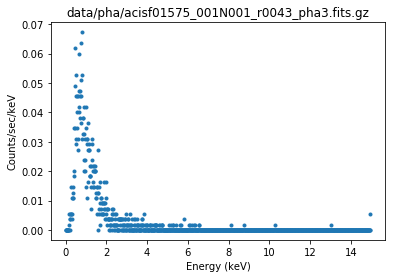

In [14]:
from sherpa.astro.plot import DataPlot

dplot = DataPlot()
dplot.prepare(pha)
dplot.plot()

### Adjust the data

The `pha` object can be controlled using methods with similar names to the functions from the `sherpa.astro.ui` module; e.g. to subtract the background, check the analysis setting, group the data, and filter an energy range I can say

In [15]:
pha.subtract()
print("Analysis setting: '{}'".format(pha.get_analysis()))
print("Number of bins  = {}".format(len(pha.get_dep(filter=True))))
pha.group_counts(20)
print("Number of bins  = {}".format(len(pha.get_dep(filter=True))))
pha.notice(0.5, 8.0)
print("Number of bins  = {}".format(len(pha.get_dep(filter=True))))

Analysis setting: 'energy'
Number of bins  = 1024
Number of bins  = 66
Number of bins  = 58


Re-creating the plot now gives a grouped and filtered view of the data:

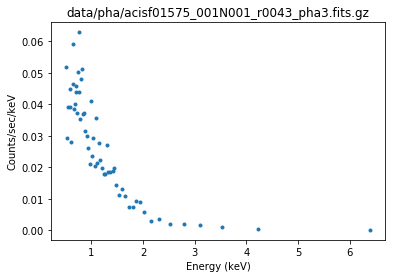

In [16]:
dplot.prepare(pha)
dplot.plot()

### Create the model

The first major difference to the `sherpa.astro.ui` layer is creating the source model, since we have to
manually add the instrumental response (that is, include the RMF and ARF). Fortunately in this case it is
relatively easy:

In [17]:
from sherpa.astro.instrument import Response1D
rsp = Response1D(pha)
print(rsp)

The `Response1D` object contains knowledge of the ARF, RMF, and PHA data sets, which means it can group and filter the evaluated model to match the data. Astute readers will note that it doesn't actually contain a model expression, so what do we have to do here? Thankfully it is simple process, in that we apply it to the model expression we want to evaluate (in this case a power law, but it can be a more-complex expression):

In [18]:
from sherpa.models.basic import PowLaw1D

pl = PowLaw1D('pl')
mdl_expr = rsp(pl)

The `Response1D` object can be thought of as acting as a [factory](https://en.wikipedia.org/wiki/Factory_%28object-oriented_programming%29) here, as the type of `mdl_expr` depends on whether the PHA data set contains an ARF or RMF.

In [19]:
print(type(mdl_expr))

<class 'sherpa.astro.instrument.RSPModelPHA'>


The basic model (i.e. without any knowledge of the ARF and RMF) is:

In [20]:
print(pl)

pl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   pl.gamma     thawed            1          -10           10           
   pl.ref       frozen            1 -3.40282e+38  3.40282e+38           
   pl.ampl      thawed            1            0  3.40282e+38           


The full model expression, including the ARF, exposure time, and RMF, is:

In [21]:
print(mdl_expr)

apply_rmf(apply_arf((37664.157219191 * pl)))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   pl.gamma     thawed            1          -10           10           
   pl.ref       frozen            1 -3.40282e+38  3.40282e+38           
   pl.ampl      thawed            1            0  3.40282e+38           


Both `pl` and `mdl_expr` are standard Sherpa models, in that they have parameter values, and can be evaluated directly. However, `pl` has no knowledge of the instrument model and so will interpret the input arguments directly, for example the bins 0.1-0.2, 0.2-0.3, ..., 0.9-1.0:

In [22]:
ebins = np.linspace(0.1, 1.0, 10)
print(pl(ebins[:-1], ebins[1:]))

[ 0.69314718  0.40546511  0.28768207  0.22314355  0.18232156  0.15415068
  0.13353139  0.11778304  0.10536052]


The `mdl_expr` model however knows about the instrument model, which defines the evaluation grid, and so ignores the input arguments:

In [23]:
y1 = mdl_expr(ebins[:-1], ebins[1:])
y2 = mdl_expr([1, 2])
y3 = mdl_expr([])

print("y1 and y2 are the same: {}".format((y1 == y2).all()))
print("y1 and y3 are the same: {}".format((y1 == y3).all()))

print("Output shape:              {}".format(y3.shape))
print("Number of channels in PHA: {}".format(len(pha.channel)))

y1 and y2 are the same: True
y1 and y3 are the same: True
Output shape:              (1024,)
Number of channels in PHA: 1024


This can then be used to evaluate the model directly - e.g. to create plots - but it is important to understand what the units are (as the model is integrated and then passed through the ARF and RMF).

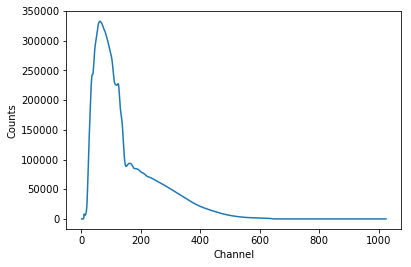

In [24]:
plt.plot(pha.channel, y1)
plt.xlabel("Channel")
plt.ylabel("Counts");

### A trick

A trick to determining what model expression to use is to load up a data set using the UI layer and then use the `sherpa.astro.ui.get_model` function. This can be useful for complicated cases, such as when multiple responses are in use (as you can get with Chandra and XMM grating spectra).

An example, using the data we have already loaded:

In [25]:
mdl_ui = ui.get_model()
print(mdl_ui)

apply_rmf(apply_arf((37664.157219191 * powlaw1d.pl)))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   pl.gamma     thawed      2.25192          -10           10           
   pl.ref       frozen            1 -3.40282e+38  3.40282e+38           
   pl.ampl      thawed  4.60287e-05            0  3.40282e+38           


In [26]:
print(type(mdl_ui))

<class 'sherpa.astro.instrument.RSPModelPHA'>


This can be compared to the model expression I created manually:

In [27]:
print(mdl_expr)

apply_rmf(apply_arf((37664.157219191 * pl)))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   pl.gamma     thawed            1          -10           10           
   pl.ref       frozen            1 -3.40282e+38  3.40282e+38           
   pl.ampl      thawed            1            0  3.40282e+38           


In [28]:
print(type(mdl_expr))

<class 'sherpa.astro.instrument.RSPModelPHA'>


Note that although both power law components are labelled as `pl` above, they refer to different objects, as shown by the fact the parameter values are different.

### Fit

Getting back to the analysis, I now need to create a `Fit` object to control the fit and error analysis. This is made slightly easier by my laziness above in using the default optimiser and statistic! Some of my
[earlier notebooks](https://github.com/DougBurke/sherpa-standalone-notebooks) can be read to find out how to set up fits using non-default values.

In [29]:
from sherpa.fit import Fit

f = Fit(pha, mdl_expr)

The fit object now contains the data and model to use:

In [30]:
print(f)

data      = data/pha/acisf01575_001N001_r0043_pha3.fits.gz
model     = apply_rmf(apply_arf((37664.157219191 * pl)))
stat      = Chi2Gehrels
method    = LevMar
estmethod = Covariance


Before starting the fit, let's just check the starting statistic (spoiler, it's not very good) and model values:

In [31]:
print("Starting statistic = {}".format(f.calc_stat()))
print("---------------------------------------------")
print(mdl_expr)

Starting statistic = 1907087634568.6655
---------------------------------------------
apply_rmf(apply_arf((37664.157219191 * pl)))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   pl.gamma     thawed            1          -10           10           
   pl.ref       frozen            1 -3.40282e+38  3.40282e+38           
   pl.ampl      thawed            1            0  3.40282e+38           


The fit itself is simple to run:

In [32]:
fres = f.fit()
if not fres.succeeded:
    print("Eek")

Let's check the results

In [33]:
print(fres.format())

Method                = levmar
Statistic             = chi2gehrels
Initial fit statistic = 1.90709e+12
Final fit statistic   = 44.3833 at function evaluation 25
Data points           = 58
Degrees of freedom    = 56
Probability [Q-value] = 0.868671
Reduced statistic     = 0.792559
Change in statistic   = 1.90709e+12
   pl.gamma       2.25191     
   pl.ampl        4.60286e-05 


How does the fit look, visually?

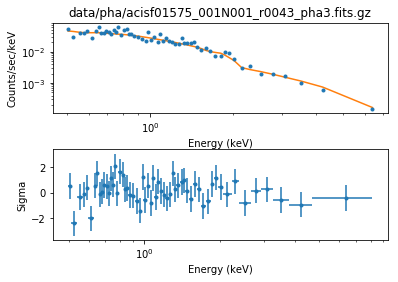

In [34]:
from sherpa.astro.plot import ModelPlot, FitPlot, DelchiPlot
from sherpa.plot import SplitPlot

dplot = DataPlot()
mplot = ModelPlot()
fplot = FitPlot()
rplot = DelchiPlot()

# Match the axis scaling of the `plot_fit_delchi` plot earlier
dplot.plot_prefs['xlog'] = True
dplot.plot_prefs['ylog'] = True
rplot.plot_prefs['xlog'] = True

dplot.prepare(pha)
mplot.prepare(pha, mdl_expr)
fplot.prepare(dplot, mplot)
rplot.prepare(pha, mdl_expr, stat=f.stat)

# remove the title from the residual plot
rplot.title = ''

splot = SplitPlot()
splot.addplot(fplot)
splot.addplot(rplot)

There is a [known issue](https://github.com/sherpa/sherpa/issues/378) in Sherpa 4.9.1 which causes residual plots to not show a line at y=0 when matplotlib version 2.0 is used.

### Error analysis

The last thing left is to calculate the parameter errors. The default error estimator is `sherpa.estmethods.Covariance`, which is the same as used by the `sherpa.astro.ui.covar` routine:

In [35]:
f.estmethod

<Covariance error-estimation method instance 'covariance'>

In [36]:
covar = f.est_errors()

The `format` method produces a display version of the results similar to that shown by `sherpa.astro.ui.covar`:

In [37]:
print(covar.format())

Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pl.gamma          2.25191   -0.0572121    0.0572121
   pl.ampl       4.60286e-05 -1.51642e-06  1.51642e-06


In [38]:
from sherpa.estmethods import Confidence
f.estmethod = Confidence()

In [39]:
conf = f.est_errors()

pl.ampl lower bound:	-1.51642e-06
pl.ampl upper bound:	1.51642e-06
pl.gamma lower bound:	-0.056587
pl.gamma upper bound:	0.0578371


In [40]:
print(conf.format())

Confidence Method     = confidence
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2gehrels
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pl.gamma          2.25191    -0.056587    0.0578371
   pl.ampl       4.60286e-05 -1.51642e-06  1.51642e-06


Let's compare the results numerically (this is just a demonstration, so only a limited number of fields are checked, but the values look pretty similar):

In [41]:
for lbl, old, new in zip(["covar", "conf"], [covar_ui, conf_ui], [covar, conf]):
    for field in ["parvals", "parmaxes"]:
        print("{:6s}  {}".format(lbl, field))
        print(getattr(old, field))
        print(getattr(new, field))
        print("")

covar   parvals
(2.2519165807242025, 4.6028655901427403e-05)
(2.2519077750835628, 4.6028620906346527e-05)

covar   parmaxes
(0.057212387026978465, 1.5164177626827971e-06)
(0.057212051752793029, 1.5164196798706763e-06)

conf    parvals
(2.2519165807242025, 4.6028655901427403e-05)
(2.2519077750835628, 4.6028620906346527e-05)

conf    parmaxes
(0.057837455844384156, 1.5164177626827952e-06)
(0.057837120569926626, 1.5164196798706731e-06)



Calculating the interval-projection is a little-more involved:

In [42]:
from sherpa.plot import IntervalProjection

In [43]:
iproj = IntervalProjection()
iproj.prepare(min=2, max=2.5, nloop=51)

# The following line performs the calculation, so can take some time if the number
# of iterations is high or there are many free parameters.
iproj.calc(f, pl.gamma)

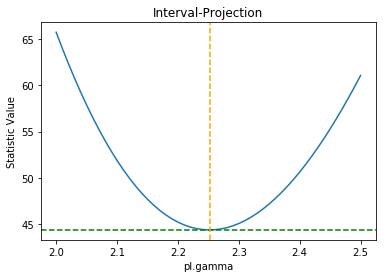

In [44]:
iproj.plot()

The fit object is used to calculate the statistic value; fortunately it agrees with the earlier version.

In [45]:
stat = f.calc_stat()
print("Statistic = {} vs {}".format(stat, stat_ui))

Statistic = 44.38328379071803 vs 44.383283673541435


## Bonus stuff

A bonus for reading this far is the following exploration of explicit model and data evaluation. The `eval_model` method of the `DataPHA` object will evaluate the model on the full grid (so all 1024 channels), whereas `eval_model_to_fit` applies any filters and grouping. This explains the difference in the number of elements shown below:

In [46]:
pha.eval_model(mdl_expr).shape

(1024,)

In [47]:
pha.eval_model_to_fit(mdl_expr).shape

(58,)

In [48]:
mdl_vals = pha.eval_model_to_fit(mdl_expr)

The trick is working out sensible values for the independent axis (i.e. the channels, or energy, or wavelengths) for the filtered and grouped data. The `apply_filter` method will filter an array (whose length should match the number of channels, so in this case 1024 elements) to match the data, and then apply a grouping function to calculate the per-group value. The default grouping function is to sum the values, but there are options to return the minimum, maxium, or the average of the minimum and maximum values in a group.

There is also an `apply_grouping` method which just performs the grouping (i.e. does not apply any filtering), but for now I am going to stick with `apply_filter`. Here I create three arrays, which give the middle, left, and right values for each group of channels.

In [49]:
chan_mid = pha.apply_filter(pha.channel, groupfunc=pha._middle)
chan_min = pha.apply_filter(pha.channel, groupfunc=pha._min)
chan_max = pha.apply_filter(pha.channel, groupfunc=pha._max)

# This will be useful below, so calculate the number of channels in each group
nchans = 1 + chan_max - chan_min

These values can be used to create a histogram plot (using the `chan_min` and `chan_max` values) or a line plot:

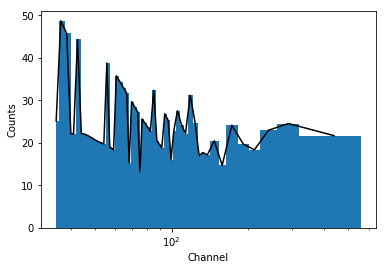

In [50]:
plt.bar(left=chan_min, height=mdl_vals, width=nchans, align='edge')
plt.plot(chan_mid, mdl_vals, 'k')
plt.xscale('log')
plt.xlabel('Channel')
plt.ylabel('Counts');

This does not match the earlier plots - e.g. created by `sherpa.astro.ui.plot_fit` or the `sherpa.astro.plot.DataPlot` class - because the Y axis here has not been normalized by the bin width (as well as the more prosaic fact that the earlier plots used energy rather than channel for the X axis):

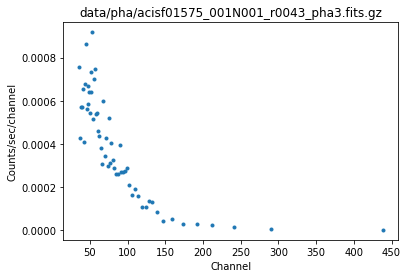

In [51]:
dplot_chan = DataPlot()
pha.set_analysis('channel')
dplot_chan.prepare(pha)

dplot_chan.plot()

To be able to visually compare the model values I have just calculated to the data - as plotted by `DataPlot` - I have to normalize by both the bin width (in channels) *and* the exposure time:

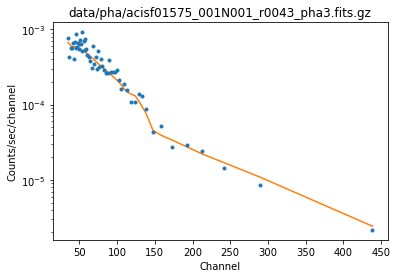

In [52]:
dplot_chan.plot()
plt.plot(chan_mid, mdl_vals / nchans / pha.exposure, '-')
plt.yscale('log')

To get the equivalent "energy" plot is a bit-more complicated, and I'm not convinced the following should be considered the "official" approach, but it works for me here! The idea is to use the `E_MIN` and `E_MAX` columns from the RMF - these give a "hand-wavy" approximation to the energies for each channel - to get the minimum and maximum energies for each group, and then manually create the center of each group:

In [53]:
elo = pha.apply_filter(mdl_expr.rmf.e_min, groupfunc=pha._min)
ehi = pha.apply_filter(mdl_expr.rmf.e_max, groupfunc=pha._max)

emid = (elo + ehi) / 2.0
ewidth = ehi - elo

This gives a reasonable looking model fit to the data (given that this is not meant to be a physically-motivated fit!):

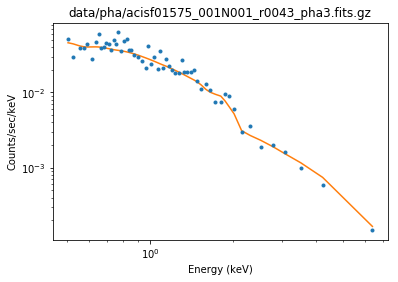

In [54]:
dplot.plot()
plt.plot(emid, mdl_vals / ewidth / pha.exposure, '-');

As a further check, here I overplot the values I calculate - as the dotted orange line - on top of the model plot created by Sherpa's `ModelPlot` class, and we can see that there's good agreement.

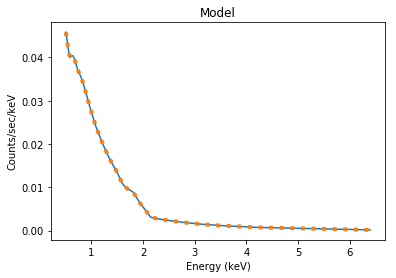

In [55]:
mplot.plot()
plt.plot(emid, mdl_vals / ewidth / pha.exposure, linestyle='dotted', lw=4);

## Bonus bonus stuff

Or should that be "Bonus$^2$ stuff"?

So far this analysis has required a PHA file along with the ARF and RMF, but it's possible to just work with the instrument responses.

In [56]:
from sherpa.astro.instrument import ARF1D, RMF1D
from sherpa.astro.io import read_arf, read_rmf

In [57]:
arf = read_arf('data/pha/acisf01575_001N001_r0043_arf3.fits.gz')
rmf = read_rmf('data/pha/acisf01575_001N001_r0043_rmf3.fits.gz')

arf_model = ARF1D(arf)
rmf_model = RMF1D(rmf)
full_expr = rmf_model(arf_model(pl))

In [58]:
print(type(full_expr))

<class 'sherpa.astro.instrument.RMFModelNoPHA'>


In [59]:
print(full_expr)

apply_rmf(apply_arf((37664.157219191 * pl)))
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   pl.gamma     thawed      2.25191          -10           10           
   pl.ref       frozen            1 -3.40282e+38  3.40282e+38           
   pl.ampl      thawed  4.60286e-05            0  3.40282e+38           


Since there is no PHA, there is no fitlering or grouping, which makes evaluation a bit simpler than above:

In [60]:
x = np.arange(rmf.offset, rmf.offset + rmf.detchans)
y = full_expr([])  # there just has to be an array-like argu,ent, but its value is ignored

To finish off, I plot the values calculated using this approach, and overplot the previously-calculated values (to show that you get similar results): 

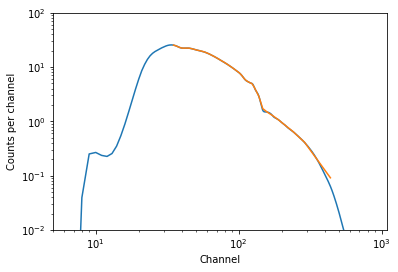

In [61]:
plt.plot(x, y)
plt.loglog()
plt.xlim(5, 1100)
plt.ylim(1e-2, 100)

plt.xlabel('Channel')
plt.ylabel('Counts per channel')

# Overplot the "grouped" values I calculated earlier
plt.plot(chan_mid, mdl_vals / nchans);

Thanks for reading this far!